In [12]:
# Necessary imports

%matplotlib inline
import torch
import torch.nn as nn
from torchvision import datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import librosa
import librosa.display


## Generate Spectrograms
Basically convert a .wav or .mp3

KeyboardInterrupt: 

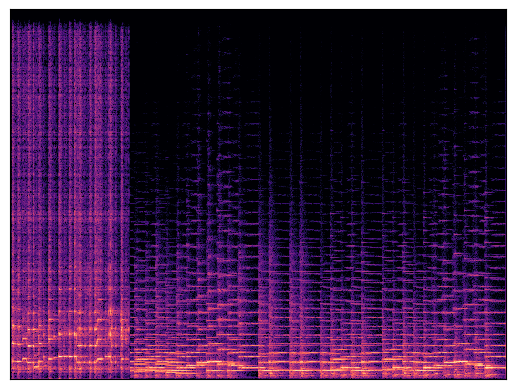

In [14]:
# Create spectrograms

# array of sound types available
sound_types = ["Snare", "Trumpet", "Violin"]

for sound_type in sound_types:

    # establish output directories
    # TODO: Add checks that directorties exist
    sound_dir = os.fsencode("../Sounds/" + sound_type)
    spec_dir = os.fsencode("../Spectrograms/" + sound_type)
    
    # remove all existing spectrograms
    for spec_file in os.listdir(spec_dir):
        
        filename = os.fsdecode(spec_file)
        
        if filename.endswith(".png"):
            os.remove(os.path.join(spec_dir, spec_file))

    for sound_file in os.listdir(sound_dir):

        filename = os.fsdecode(sound_file)

        if filename.endswith(".wav") or filename.endswith(".mp3" or filename.endswith(".flac")):

            y, sr = librosa.load(os.path.join(sound_dir, sound_file))

                        # Compute the Short-Time Fourier Transform (STFT)
            D = librosa.stft(y)

            # Convert the amplitude spectrogram to decibels
            D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

            # Plot the spectrogram without axis labels or scales
            librosa.display.specshow(D_db, sr=sr, x_axis=None, y_axis=None)

            # Save the spectrogram as a PNG file
            output_file = os.path.join(spec_dir, os.fsencode(os.path.splitext(filename)[0] + ".png"))
            plt.savefig(output_file, bbox_inches='tight', pad_inches=0)

In [11]:
# Create arrays of ground truth data

sound_types = ["Snare", "Trumpet", "Violin"]

data = []

for sound_type in sound_types:

    # establish output directories
    # TODO: Add checks that directorties exist
    spec_dir = os.fsencode("../Spectrograms/" + sound_type)
    
    # remove all existing spectrograms
    for spec_file in os.listdir(spec_dir):
        
        filename = os.fsdecode(spec_file)
        
        if filename.endswith(".png"):

            data.append(filename, sound_type)

data

[['snare_027.png',
  'snare_066.png',
  'snare_003.png',
  'snare_017.png',
  'snare_028.png',
  'snare_012.png',
  'snare_018.png',
  'snare_049.png',
  'snare_046.png',
  'snare_030.png',
  'snare_015.png',
  'snare_062.png',
  'snare_011.png',
  'snare_074.png',
  'snare_031.png',
  'snare_098.png',
  'snare_077.png',
  'snare_005.png',
  'snare_020.png',
  'snare_019.png',
  'snare_001.png',
  'snare_073.png',
  'snare_045.png',
  'snare_048.png',
  'snare_052.png',
  'snare_050.png',
  'snare_002.png',
  'snare_053.png',
  'snare_056.png',
  'snare_029.png',
  'snare_035.png',
  'snare_051.png',
  'snare_013.png',
  'snare_061.png',
  'snare_023.png',
  'snare_079.png',
  'snare_058.png',
  'snare_064.png',
  'snare_060.png',
  'snare_063.png',
  'snare_080.png',
  'snare_071.png',
  'snare_097.png',
  'snare_043.png',
  'snare_075.png',
  'snare_041.png',
  'snare_006.png'],
 ['Snare',
  'Snare',
  'Snare',
  'Snare',
  'Snare',
  'Snare',
  'Snare',
  'Snare',
  'Snare',
  'Snar

## Generate spectrograms for the first second
A spectrogram of fixed time length is computed for each audio file

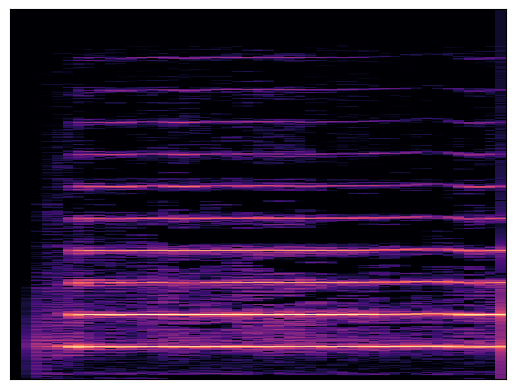

In [4]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Path to the audio file
# file_path = "C:/Users/pilla/Desktop/Git/4114_Project/EEE4114F-Project/Sounds/Snares/3147__robbiesurp__dm_snare_ringger.wav"
file_path = "Sounds/Trumpet/trumpet_003.mp3"

# Check if the file exists
if not os.path.exists(file_path):
    print("File not found:", file_path)
    exit()

# Load the audio file
y, sr = librosa.load(file_path, sr=None)

# Take only the first second of the audio
y_first_second = y[:sr]

# Compute the Short-Time Fourier Transform (STFT) of the first second
D = librosa.stft(y_first_second)

# Convert the amplitude spectrogram to decibels
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram without axis labels or scales
librosa.display.specshow(D_db, sr=sr, x_axis=None, y_axis=None)

# Save the spectrogram as a PNG file
output_dir = "Spectrograms/Trumpet"
output_file = os.path.join(output_dir, "spectrogram_first_second.png")
plt.savefig(output_file, bbox_inches='tight', pad_inches=0)

plt.show()
